<a href="https://colab.research.google.com/github/as2c/MLP---Cosmology/blob/NewData/Optimization2/RandomForest_data2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, our objective is to train some classic models such as SVM, KNN, RandomForest, etc on our test data, and try to evaluate their efficiency by plotting confusion matrixes, learning curves, validation curves, and measuring the prediction time. 

# Import phase I data

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import timeit
import time
%alias_magic t timeit
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Gadget 2 Data / with Neutrino

In [3]:
data = pd.read_csv(r'/content/drive/MyDrive/denc_Neutrino')
# data['in_halo'] = (data['haloID']>0).astype('int')
data['in_halo'] = (data['halo_mass']>1600).astype('int32')
data

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,10156552,755,2280.0,171.21194,220.56293,-274.228700,-0.084922,-0.052028,-0.042415,-0.028087,-0.024984,-0.018675,-0.016231,-0.011940,-0.010111,1
1,11068486,85,1539.0,-129.84116,92.60424,212.125500,-0.127820,-0.081099,-0.051217,-0.028345,-0.013751,-0.013991,-0.012344,-0.011500,-0.012220,0
2,9530036,654,1944.0,-290.99210,-885.49430,468.255040,-0.078978,-0.052806,-0.030027,-0.011704,0.001295,0.003803,0.005131,0.005231,0.003787,1
3,11455022,752,1394.0,-60.35258,422.43716,79.394300,-0.109989,-0.079155,-0.054663,-0.037685,-0.026670,-0.017901,-0.009227,-0.000868,0.001568,0
4,8591034,356,1649.0,403.66608,345.88077,9.231552,-0.084405,-0.019068,-0.009396,-0.001539,0.002288,0.005629,0.011288,0.013111,0.013433,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2160800,451,2634.0,654.82430,210.78130,255.344150,-0.094225,-0.076043,-0.060624,-0.040368,-0.020840,-0.016261,-0.011803,-0.005002,0.000918,1
99996,3257728,43,1112.0,-154.27774,488.65564,-779.558400,-0.127045,-0.076529,-0.056246,-0.038201,-0.027520,-0.016374,-0.008045,0.002627,0.006124,0
99997,6101605,484,1198.0,-113.51735,68.44336,275.964000,-0.122135,-0.091794,-0.063465,-0.032060,-0.017973,-0.016684,-0.017740,-0.017154,-0.012600,0
99998,4576456,44,1058.0,-130.21120,292.63483,-754.563000,-0.097585,-0.076140,-0.061788,-0.054584,-0.043055,-0.032415,-0.021591,-0.007463,0.004673,0


In [4]:
data.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.716004e+06,424.627710,2369.299450,35.207601,-13.728656,97.821939,-0.107338,-0.062074,-0.038666,-0.025951,-0.017900,-0.011968,-0.007224,-0.003341,-0.000224,0.557930
std,3.549230e+06,230.962533,1856.527585,364.820655,369.919751,373.578625,0.020301,0.020965,0.019921,0.018106,0.015956,0.013969,0.012346,0.011069,0.010084,0.496635
min,2.131444e+06,16.000000,241.000000,-1247.932500,-1462.806300,-1250.519700,-0.127820,-0.099572,-0.083351,-0.072824,-0.065316,-0.058751,-0.050519,-0.043771,-0.038371,0.000000
25%,5.953820e+06,238.000000,1194.000000,-226.284345,-254.656135,-145.829085,-0.124202,-0.077891,-0.052474,-0.038510,-0.028860,-0.021233,-0.015384,-0.010712,-0.006964,0.000000
50%,9.043250e+06,418.000000,1791.000000,32.857450,-4.815737,101.883413,-0.113607,-0.063404,-0.039434,-0.026100,-0.017784,-0.011980,-0.007369,-0.003743,-0.000713,1.000000
75%,1.176120e+07,619.000000,2945.000000,284.168098,238.543252,350.062135,-0.095776,-0.048722,-0.025370,-0.013587,-0.006677,-0.002087,0.001081,0.004249,0.006694,1.000000
max,1.464652e+07,870.000000,10101.000000,1314.092800,1256.822900,1355.984900,0.017155,0.032463,0.044346,0.040490,0.042179,0.036009,0.033482,0.034145,0.032602,1.000000


### Gadget 2 Data / without Neutrino

In [5]:
data_cdm = pd.read_csv(r'/content/drive/MyDrive/denc_CDM')
data_cdm['in_halo'] = (data_cdm['halo_mass']>1600).astype('int32')
data_cdm

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
0,8981131,414,1504.0,252.710050,-464.239500,509.94550,2.817576,2.780794,2.746420,2.446413,2.000415,1.533108,1.083378,0.691070,0.457584,0
1,9901676,1026,1013.0,-167.701370,499.161740,156.32635,2.690323,2.102417,1.805493,1.485764,1.267945,1.083753,0.849938,0.617267,0.431845,0
2,8288987,1079,727.0,46.129280,19.954561,164.61870,1.010590,0.821528,0.559744,0.220796,0.003400,-0.094805,-0.074599,0.003315,0.076079,0
3,4842631,675,1268.0,-234.629320,349.021400,-690.46674,1.889611,1.180236,0.495534,0.064434,-0.232441,-0.389582,-0.407908,-0.334146,-0.231578,0
4,12884124,437,6128.0,146.780670,-180.209270,-558.39777,2.676619,1.734870,0.906903,0.464721,0.187801,0.057663,0.029529,0.049055,0.101472,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,12466311,1085,5542.0,25.253933,-580.586850,113.06337,1.482403,1.068278,0.857863,0.583947,0.327563,0.212553,0.139374,0.103515,0.090791,1
99996,11857185,491,691.0,-423.371550,138.109020,-300.80450,-0.209077,-0.534490,-0.724460,-0.749430,-0.743152,-0.663805,-0.511928,-0.347015,-0.253660,0
99997,9340191,947,868.0,225.385210,-9.085627,318.22006,1.086942,0.492283,0.114506,-0.050883,-0.161068,-0.168421,-0.159639,-0.175261,-0.202931,0
99998,13317963,1034,1175.0,-55.431606,16.332230,-898.90326,0.339088,-0.085185,-0.248881,-0.328230,-0.343797,-0.306353,-0.275684,-0.282089,-0.284524,0


In [6]:
data_cdm.describe()

,id,haloID,halo_mass,vx,vy,vz,dc for 4.9,dc for 6.8,dc for 8.7,dc for 10.6,dc for 12.4,dc for 14.3,dc for 16.2,dc for 18.1,dc for 20.0,in_halo
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,8.533738e+06,633.075900,3004.391080,32.287533,-13.697343,89.574071,1.423915,1.032233,0.712873,0.480862,0.322917,0.216223,0.144046,0.096634,0.066060,0.589200
std,3.598448e+06,358.496156,2802.876192,359.880883,364.383569,374.571567,1.023549,0.920945,0.807251,0.689640,0.585773,0.502089,0.436403,0.384151,0.341271,0.491981
min,2.131195e+06,3.000000,271.000000,-1234.874100,-1571.376600,-1311.024700,-0.994127,-0.912349,-0.878283,-0.891915,-0.933043,-0.935449,-0.868262,-0.815454,-0.787467,0.000000
25%,5.640789e+06,368.000000,1181.000000,-223.982345,-249.685410,-148.388917,0.660156,0.354545,0.122621,-0.026842,-0.107359,-0.161173,-0.183527,-0.186967,-0.181568,0.000000
50%,8.790886e+06,676.000000,2020.000000,28.124724,-4.978945,97.944227,1.269011,0.890765,0.589027,0.370513,0.223129,0.134561,0.074502,0.037988,0.011761,1.000000
75%,1.143724e+07,970.000000,3662.000000,277.156240,231.618633,341.305498,2.057976,1.549992,1.162333,0.872826,0.674880,0.526476,0.422276,0.353801,0.294427,1.000000
max,1.464654e+07,1251.000000,31252.000000,1362.093800,1185.835400,1349.211900,5.624963,4.721646,3.972765,3.400808,2.783131,2.163220,1.888203,1.618024,1.364662,1.000000


## Define Datasets

In [7]:
## Neutrino
X = data.iloc[:,3:15].astype('float32').values
Y = data.in_halo.astype('int32').values

In [8]:
## CDM
X2 = data_cdm.iloc[:,3:15].astype('float32').values
Y2 = data_cdm.in_halo.astype('int32').values

In [9]:
## Scale / Neutrino
X = (X - np.mean(X))/np.std(X)

In [10]:
## Scale / CDM
X2 = (X2 - np.mean(X2))/np.std(X2)

In [11]:
## Split into test and train / Neutrino

tst_size = 0.2
ns, nf = np.shape(X) 
X_train, X_test, Y_train, Y_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X_train :',len(X_train),'   X_test :',len(X_test))

X_train : 80000    X_test : 20000


In [12]:
## Split into test and train / CDM

tst_size = 0.2
ns, nf = np.shape(X) 
X2_train, X2_test, Y2_train, Y2_test = train_test_split(*shuffle(X, Y, n_samples = ns, random_state=0) , random_state=0, test_size =tst_size )
print('X2_train :',len(X2_train),'   X2_test :',len(X2_test))

X2_train : 80000    X2_test : 20000


In [13]:
# Frequency of 1-class / Neutrino
print("{} % of the stored data has class 1 ".format(100*Y.sum()/len(Y)))

55.793 % of the stored data has class 1 


In [14]:
# Frequency of 1-class / CDM
print("{} % of the stored data has class 1 ".format(100*Y2.sum()/len(Y2)))

58.92 % of the stored data has class 1 


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
#check 
%t classifier.fit(X_train , Y_train)

#Testing the classification on the test sample
Y_predict = classifier.predict(X_test)
#check
%t Y_predict = classifier.predict(X_test)
print(len(Y_test))
print(len(Y_predict[Y_predict== 1]))

1 loop, best of 5: 4.94 s per loop
10 loops, best of 5: 102 ms per loop
20000
13725


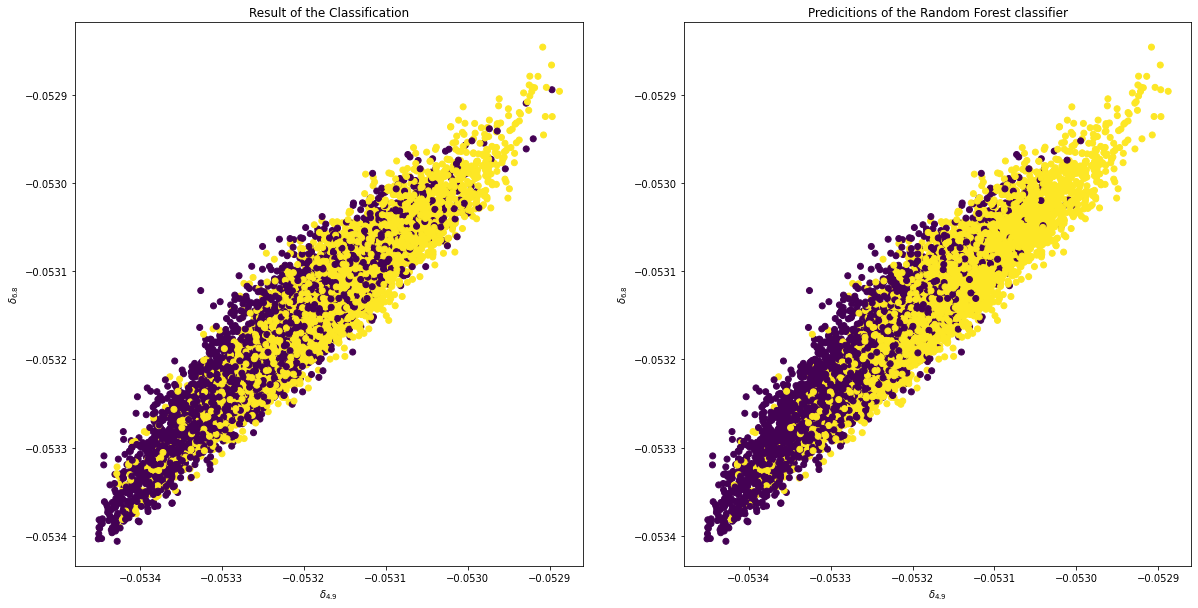

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta_{4.9}$', ylabel='$\delta_{6.8}$' , title = 'Result of the Classification')

ax.scatter(*X_test[:,6:8].T, c=Y_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta_{4.9}$ ', ylabel='$\delta_{6.8}$', title = 'Predicitions of the Random Forest classifier')
plt.scatter(*X_test[:,6:8].T, c = Y_predict)
plt.show()


### The Classification Report 

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y_test, Y_predict)
print(clf_report)

              precision    recall  f1-score   support

           0       0.72      0.51      0.60      8852
           1       0.69      0.84      0.76     11148

    accuracy                           0.70     20000
   macro avg       0.70      0.68      0.68     20000
weighted avg       0.70      0.70      0.69     20000



### Fine Tunning The Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Random search of parameters, using 2 fold cross validation, 
# search across 10 different combinations, and use all available cores
print('start')
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1, refit=True)
# Fit the random search model
rf_random.fit(X_train, Y_train)

print(rf_random.best_params_)

start
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


### Learning Curve

In [ ]:
#first we should do the classification with the optimal values.

classifier = rf_random.best_estimator_

train_sizes = np.linspace(1000,80000,5, dtype='int')

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= classifier , X = X,
                                                   y = Y, train_sizes = train_sizes, cv = 5, random_state = 0)

print('Training scores:\n\n', pd.DataFrame( train_scores) )

print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

## runtime order = 3 hr

Training scores:

      0    1    2    3    4
0  1.0  1.0  1.0  1.0  1.0
1  1.0  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0  1.0

Validation scores:

          0        1        2        3        4
0  0.70190  0.68645  0.69040  0.69035  0.69430
1  0.79415  0.79440  0.79990  0.79330  0.79675
2  0.82720  0.82440  0.83065  0.82065  0.82445
3  0.84510  0.84165  0.84615  0.83825  0.84155
4  0.85665  0.85380  0.85940  0.85070  0.85570


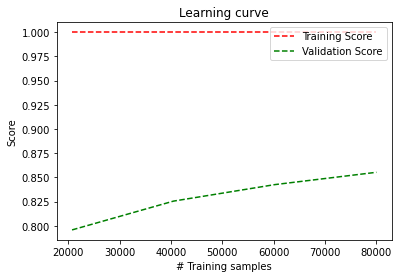

In [ ]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.title('Learning curve')
plt.plot(ns_list[1:], train_scores_mean[1:],'r--',label = 'Training Score')
plt.plot(ns_list[1:], validation_scores_mean[1:], 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

### Training with optimized hyperparameter

In [15]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y , test_size = 0.09 , random_state= 0)
X_test = np.array(X_test)
X_train = np.array(X_train)
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)
X = np.array(X)
Y = np.array(Y)

In [15]:
classifier = RandomForestClassifier(n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1, 
                                    max_features = 'sqrt', max_depth = 110, bootstrap = True, random_state=0)
start_train = time.time()
classifier.fit(X_train , Y_train)
runtime_train = time.time() - start_train

#Testing the classification on the test sample

start_pred = time.time()
Y_predict = classifier.predict(X_test)
runtime_pred = time.time() - start_pred

Y_predict = classifier.predict(X_test)
Y_train_pred = classifier.predict(X_train)

print(len(Y_test))
print(len(Y_predict[Y_predict == 1]))

20000
11835


### Feature Importances

In [ ]:
#Evaluating the new trained model:
from sklearn.metrics import classification_report
final_report = classification_report(Y_test, Y_predict)
print(final_report)

              precision    recall  f1-score   support

           0       0.85      0.78      0.82      8852
           1       0.84      0.89      0.86     11148

    accuracy                           0.84     20000
   macro avg       0.84      0.84      0.84     20000
weighted avg       0.84      0.84      0.84     20000



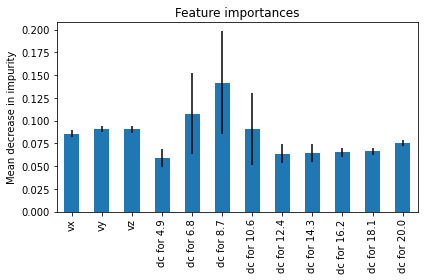

In [25]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(data)[3:15])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

###Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test , Y_predict, labels = (1,0))
print('Here is the confusion matrix for the LG classifier: \n'  )
print('TP = {}'.format(conf_matrix[0][0]),'  FP = {}'.format(conf_matrix[0][1]) , '\n')
print('FN = {}'.format(conf_matrix[1][0]),'  TN = {}'.format(conf_matrix[1][1]) , '\n')

Here is the confusion matrix for the LG classifier: 

TP = 4539   FP = 492 

FN = 871   TN = 3098 



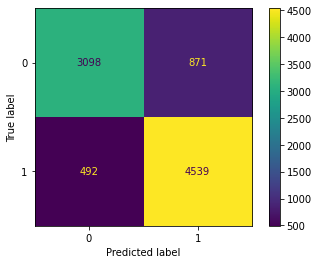

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix( classifier, X_test, Y_test)  
plt.show()

###Accuracy

$Accuracy = \frac{TP + TN}{TP+TN+FP+FN} * 100$

In [ ]:
acurracy = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
print('The accuracy of the model is {}%' .format(round(acurracy*100, 3)))

The accuracy of the model is 84.856%


## Precision - Recall curve

[[0.5221284  0.4778716 ]
 [0.48283022 0.51716978]
 [0.40351077 0.59648923]
 ...
 [0.28887585 0.71112415]
 [0.18908586 0.81091414]
 [0.32660913 0.67339087]]
[0 1 1 ... 1 1 1]


(0.0, 1.0)

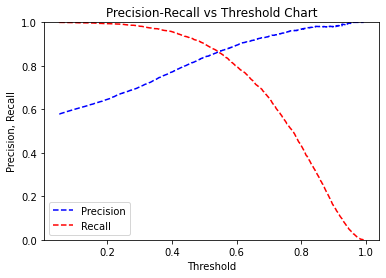

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
#getting the probability of being in each class from classifier without applying the threshold
Y_probs=classifier.predict_proba(X_test) 
print(Y_probs)
print(Y_predict)
precision, recall, thresholds = precision_recall_curve(Y_test , Y_probs[:, 1]) 

#retrieve probability of being 1(in second column of Y_prob)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

As can be seen, increasing precision will result in a decrease in the recall and vice versa. The trade-off point between precision and recall is where the two curves coincide, around the threshold = 0.5, and will result in precision and recalls equal to 0.5. 

In [ ]:
from sklearn.metrics import accuracy_score
EM1 = 'accuracy'
CPS1 = accuracy_score(Y_test, Y_predict)
CVS1 = accuracy_score(Y_train_pred, Y_train)

T1 = runtime_train
PT1 = runtime_pred
print( "Training Time was: " + str(T1))
print("Prediction Time was: " + str(PT1))

Training Time was: 2684.946999311447
Prediction Time was: 49.58787727355957


In [ ]:
# Here we tried to make an estimation of Bias and Variance
%pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        classifier, X_train, Y_train, X_test, Y_test)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)


# runtime was too long

# Random Forest / CDM

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=10, random_state=0)
#check 
%t classifier.fit(X2_train , Y2_train)

#Testing the classification on the test sample
Y2_predict = classifier.predict(X2_test)
#check
%t Y2_predict = classifier.predict(X2_test)
print(len(Y2_test))
print(len(Y2_predict[Y2_predict== 1]))

1 loop, best of 5: 19.3 s per loop
1 loop, best of 5: 267 ms per loop
20000
12950


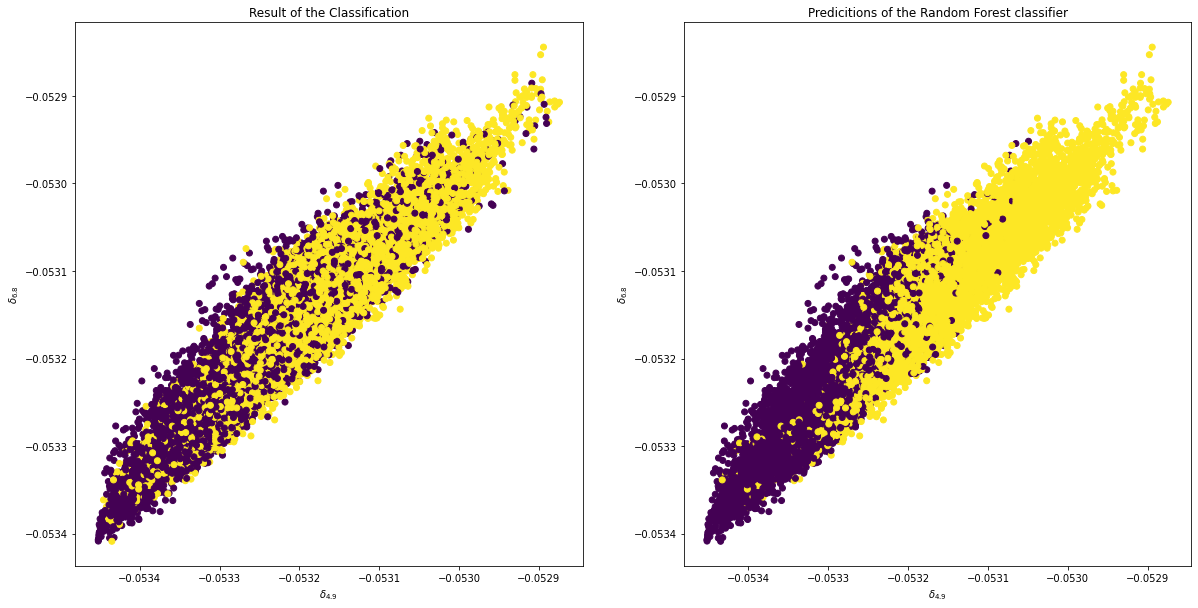

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121 , xlabel = '$\delta_{4.9}$', ylabel='$\delta_{6.8}$' , title = 'Result of the Classification')

ax.scatter(*X2_test[:,6:8].T, c=Y2_test)    

ax = fig.add_subplot(122 , xlabel = '$\delta_{4.9}$ ', ylabel='$\delta_{6.8}$', title = 'Predicitions of the Random Forest classifier')
plt.scatter(*X2_test[:,6:8].T, c = Y2_predict)
plt.show()


### The Classification Report 

In [ ]:
from sklearn.metrics import classification_report
clf_report = classification_report(Y2_test, Y2_predict)
print(clf_report)

              precision    recall  f1-score   support

           0       0.75      0.60      0.67      8852
           1       0.73      0.84      0.78     11148

    accuracy                           0.73     20000
   macro avg       0.74      0.72      0.72     20000
weighted avg       0.74      0.73      0.73     20000



### Fine Tunning The Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 12)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Random search of parameters, using 2 fold cross validation, 
# search across 10 different combinations, and use all available cores
print('start')
rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1, refit=True)
# Fit the random search model
rf_random.fit(X2_train, Y2_train)

print(rf_random.best_params_)

start
Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


### Learning Curve

In [ ]:
#first we should do the classification with the optimal values.

train_sizes = np.linspace(1000,80000,5, dtype='int')

#computing training score and validation score for each sample size cv times
ns_list, train_scores, validation_scores = learning_curve(
                                                   estimator= classifier , X = X2,
                                                   y = Y2, train_sizes = train_sizes, cv = 5, random_state = 0)

print('Training scores:\n\n', pd.DataFrame( train_scores) )

print('\nValidation scores:\n\n', pd.DataFrame(validation_scores) )

## runtime order = 3 hr

Training scores:

           0         1         2         3         4
0  0.999000  1.000000  1.000000  1.000000  1.000000
1  0.999663  0.999807  0.999904  0.999904  0.999904
2  0.999654  0.999901  0.999778  0.999778  0.999778
3  0.999784  0.999801  0.999768  0.999784  0.999801
4  0.999812  0.999775  0.999788  0.999762  0.999838

Validation scores:

          0        1        2        3        4
0  0.72610  0.71890  0.71885  0.72030  0.72140
1  0.80785  0.80610  0.80755  0.81020  0.80830
2  0.83645  0.83550  0.83735  0.83910  0.83580
3  0.85180  0.85235  0.85335  0.85390  0.85270
4  0.86215  0.86585  0.86735  0.86695  0.86655


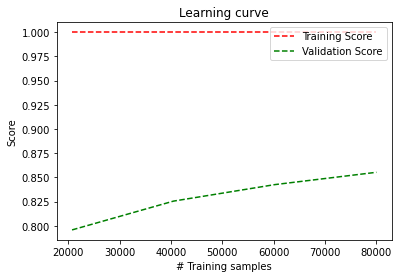

In [ ]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)

plt.title('Learning curve')
plt.plot(ns_list[1:], train_scores_mean[1:],'r--',label = 'Training Score')
plt.plot(ns_list[1:], validation_scores_mean[1:], 'g--', label = 'Validation Score')
plt.xlabel('# Training samples')
plt.ylabel('Score')
plt.legend(loc='upper right')

plt.show()

In [26]:
X2_train, X2_test, Y2_train, Y2_test  = train_test_split(X2, Y2 , test_size = 0.09 , random_state= 0)

### Training with optimized hyperparameter

In [28]:
classifier2 = RandomForestClassifier(n_estimators = 1400, min_samples_split = 5, min_samples_leaf = 1, 
                                    max_features = 'sqrt', max_depth = 110, bootstrap = True, random_state=0)
start_train = time.time()
classifier2.fit(X2_train , Y2_train)
runtime_train = time.time() - start_train

#Testing the classification on the test sample

# start_pred = time.time()
# Y2_predict = classifier2.predict(X2_test)
# runtime_pred = time.time() - start_pred

# Y2_predict = classifier2.predict(X2_test)
# Y2_train_pred = classifier2.predict(X2_train)

# print(len(Y2_test))
# print(len(Y2_predict[Y2_predict == 1]))

In [ ]:
#Evaluating the new trained model:
final_report = classification_report(Y2_test, Y2_predict)
print(final_report)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3658
           1       0.86      0.93      0.90      5342

    accuracy                           0.87      9000
   macro avg       0.87      0.86      0.86      9000
weighted avg       0.87      0.87      0.87      9000



### Feature Importances

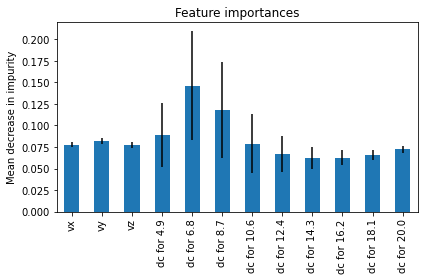

In [29]:
importances = classifier2.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier2.estimators_], axis=0)

forest_importances = pd.Series(importances, index=list(data)[3:15])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

###Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y2_test , Y2_predict, labels = (1,0))
print('Here is the confusion matrix for the LG classifier: \n'  )
print('TP = {}'.format(conf_matrix[0][0]),'  FP = {}'.format(conf_matrix[0][1]) , '\n')
print('FN = {}'.format(conf_matrix[1][0]),'  TN = {}'.format(conf_matrix[1][1]) , '\n')

Here is the confusion matrix for the LG classifier: 

TP = 4978   FP = 364 

FN = 804   TN = 2854 



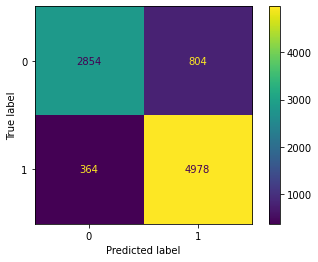

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix( classifier2, X2_test, Y2_test)  
plt.show()

###Accuracy

$Accuracy = \frac{TP + TN}{TP+TN+FP+FN} * 100$

In [ ]:
acurracy = (conf_matrix[0][0]+conf_matrix[1][1])/(conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]+conf_matrix[1][1])
print('The accuracy of the model is {}%' .format(round(acurracy*100, 3)))

The accuracy of the model is 87.022%


## Precision - Recall curve

[[0.36550904 0.63449096]
 [0.02905612 0.97094388]
 [0.35189881 0.64810119]
 ...
 [0.16743312 0.83256688]
 [0.09269882 0.90730118]
 [0.1590907  0.8409093 ]]
[1 1 1 ... 1 1 1]


(0.0, 1.0)

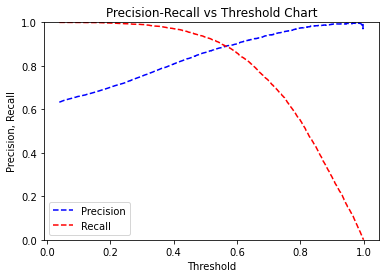

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
#getting the probability of being in each class from classifier without applying the threshold
Y2_probs=classifier2.predict_proba(X2_test) 
print(Y2_probs)
print(Y2_predict)
precision, recall, thresholds = precision_recall_curve(Y2_test , Y2_probs[:, 1]) 

#retrieve probability of being 1(in second column of Y2_prob)
pr_auc = auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

As can be seen, increasing precision will result in a decrease in the recall and vice versa. The trade-off point between precision and recall is where the two curves coincide, around the threshold = 0.5, and will result in precision and recalls equal to 0.5. 

In [ ]:
from sklearn.metrics import accuracy_score
EM2 = 'accuracy'
CPS2 = accuracy_score(Y2_test, Y2_predict)
CVS2= accuracy_score(Y2_train_pred, Y2_train)

T2 = runtime_train
PT2 = runtime_pred
print( "Training Time was: " + str(T2))
print("Prediction Time was: " + str(PT2))

Training Time was: 3350.478899717331
Prediction Time was: 23.1524760723114


In [ ]:
# Here we tried to make an estimation of Bias and Variance
%pip install mlxtend --upgrade
from mlxtend.evaluate import bias_variance_decomp
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        classifier, X_train, Y_train, X_test, Y_test)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)


# runtime was too long

# Comparing Models

A table is created to compare the five recently-traind models above. It includes evaluation metric(s), training time and prediction time of each models. Also, we sorted models based on their performance from different aspects. 

In [ ]:
table = pd.DataFrame({'Name':['Neutrino','CDM'],
                        'Evaluation Metric(s)': [EM1, EM2],
                        'Corresponding Validation Score': [CVS1, CVS2],
                        'Corresponding Prediction Score':  [CPS1, CPS2],
                        'Training Time': [T1, T2],
                        'Prediction Time': [PT1, PT2]
})

print('Sort models based on their validation scores: \n' + str(table.sort_values(by=['Corresponding Validation Score'], ascending= False).loc[:, ['Name', 'Corresponding Validation Score']]))
print('\nSort models based on their prediction scores: \n' + str(table.sort_values(by=['Corresponding Prediction Score'], ascending= False).loc[:, ['Name', 'Corresponding Prediction Score']]))
print('\nSort models based on their training time: \n' + str(table.sort_values(by=['Training Time'], ascending= True).loc[:, ['Name', 'Training Time']]))
print('\nSort models based on their prediction time: \n' + str(table.sort_values(by=['Prediction Time'], ascending= True).loc[:, ['Name', 'Prediction Time']]))


Sort models based on their validation scores: 
       Name  Corresponding Validation Score
0  Neutrino                        0.999900
1       CDM                        0.999769

Sort models based on their prediction scores: 
       Name  Corresponding Prediction Score
1       CDM                        0.870222
0  Neutrino                        0.843750

Sort models based on their training time: 
       Name  Training Time
0  Neutrino    2684.946999
1       CDM    3350.478900

Sort models based on their prediction time: 
       Name  Prediction Time
1       CDM        23.152476
0  Neutrino        49.587877
